In [7]:
from preprocess import get_prepared_data
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
# Load preprocessed, prepared data with original labels
# We want to divide the data into original 5 classes
# And change the shape to (n_samples, 178, 1) because DTW requires 3-dimensional vectors
X, y = get_prepared_data(oversample=False, relabel=False, standard_scaler=False, time_series_scaler=True, time_series_reshape=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# KNN classifier on time series but using DTW instead of euclidean distance
knn_dtw = KNeighborsTimeSeriesClassifier(
    n_neighbors=3,
    metric="dtw",
    metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 10},   # chat powiedzial ze to jakis opt -> sprawdzic
    n_jobs=-1  # Wykorzystanie wszystkich rdzeni CPU
)

In [23]:
# Extracting some basic statistic features from every sample for Random Forest classifier
def extract_features(X):
    features = []
    for series in X:
        series = series.flatten()
        features.append([
            np.mean(series),
            np.std(series),
            np.min(series),
            np.max(series),
            np.percentile(series, 25),
            np.percentile(series, 75),
            np.median(series),
            np.sum(np.diff(series) ** 2),  # Energia pierwszej pochodnej
            len(np.where(np.diff(series) > 0)[0]) / len(series),  # Proporcja wzrostów
        ])
    return np.array(features)


# Random Forest pipeline
rf_pipeline = Pipeline([
    ('feature_extraction', FunctionTransformer(extract_features)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [25]:
# Training models
print("Training KNN-DTW...")
knn_dtw.fit(X_train, y_train)

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

Training KNN-DTW...
Training Random Forest...


KeyboardInterrupt: 

In [ ]:
# Predictions
y_pred_knn = knn_dtw.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# Ensemble - majority vote 
# this way we should get the best results 
y_pred_ensemble = np.array([
    max(set([pred1, pred2]), key=[pred1, pred2].count)
    for pred1, pred2 in zip(y_pred_knn, y_pred_rf)
])

Trenowanie KNN-DTW...
Trenowanie Random Forest...

KNN-DTW Results:
              precision    recall  f1-score   support

           1       0.76      0.83      0.79       460
           2       0.60      0.70      0.65       460
           3       0.59      0.61      0.60       460
           4       0.65      0.68      0.67       460
           5       0.54      0.36      0.43       460

    accuracy                           0.64      2300
   macro avg       0.63      0.64      0.63      2300
weighted avg       0.63      0.64      0.63      2300



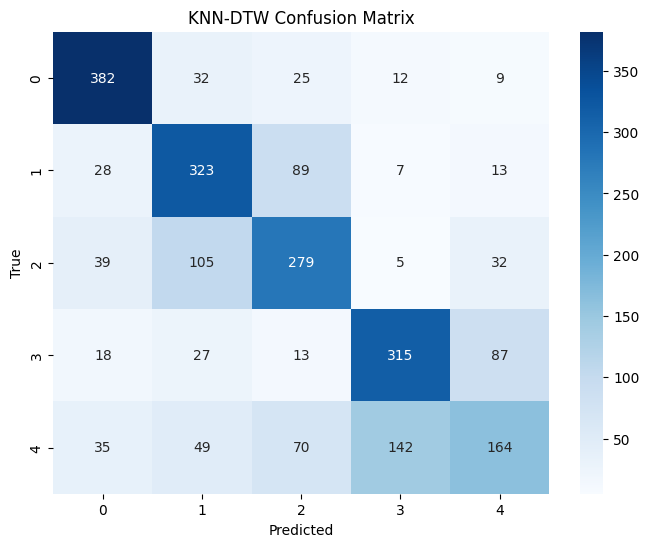


Random Forest Results:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       460
           2       0.66      0.58      0.61       460
           3       0.64      0.61      0.62       460
           4       0.75      0.75      0.75       460
           5       0.69      0.78      0.73       460

    accuracy                           0.74      2300
   macro avg       0.74      0.74      0.74      2300
weighted avg       0.74      0.74      0.74      2300



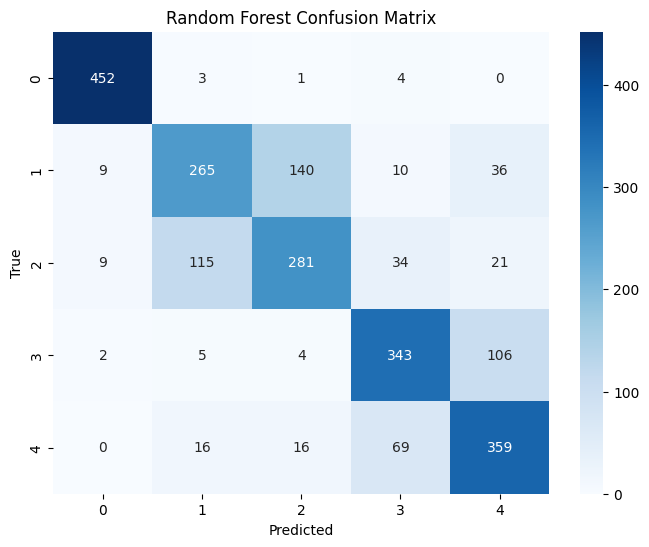


Ensemble Results:
              precision    recall  f1-score   support

           1       0.77      0.99      0.87       460
           2       0.57      0.80      0.67       460
           3       0.63      0.48      0.54       460
           4       0.66      0.78      0.72       460
           5       0.73      0.28      0.40       460

    accuracy                           0.67      2300
   macro avg       0.67      0.67      0.64      2300
weighted avg       0.67      0.67      0.64      2300



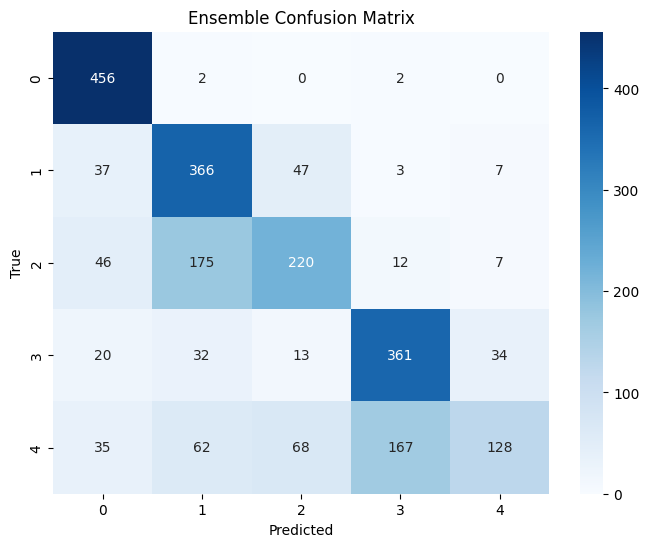

In [ ]:
# Print the results
# Some metrics are scam :(
def print_results(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_results(y_test, y_pred_knn, "KNN-DTW")
print_results(y_test, y_pred_rf, "Random Forest")
print_results(y_test, y_pred_ensemble, "Ensemble")